In [49]:
import sys
import argparse
from typing import List, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf

In [50]:
# TO REMOVE - old version of splitting data
def split_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    ecg_0 = df.iloc[::2, 2:].to_numpy()
    ecg_1 = df.iloc[1::2, 2:].to_numpy()
    print(ecg_0[1])

    train_ecg_1, labels_ecg_1 = ecg_0[:, :-1], ecg_0[:, -1]
    train_ecg_2, labels_ecg_2 = ecg_1[:, :-1], ecg_1[:, -1]

    return train_ecg_1.astype(np.float32), labels_ecg_1.astype(np.float32), train_ecg_2.astype(np.float32), labels_ecg_2.astype(np.float32)

In [ ]:
# TO REMOVE - old version of splitting data
dummy = {
    'n': 0,
    's': 1,
    't': 2
}
dataset_path = './datasets/dataset_sample_freq_12.csv'

df = pd.read_csv(dataset_path)
labels = df['13'].unique()
df['13'] = np.array([dummy[label] for label in df['13']]).astype(np.float32)

train_x1, train_y1, train_x2, train_y2 = split_data(df)
train_x1.shape

In [ ]:
# TO REMOVE - old version of splitting data
def split_data2(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:

    ecg = df.iloc[::2, 2:].to_numpy()

    train_ecg, labels_ecg = ecg[:, :-1], ecg[:, -1]

    return train_ecg.astype(np.float32), labels_ecg.astype(np.float32), 

dummy = {
    'n': 0,
    's': 2,
    't': 1
}
# dataset_path = './datasets/dataset_sample_freq_1.csv'
dataset_path = './dataset.csv'

df = pd.read_csv(dataset_path)
df = df[df['33'] != 's']
labels = df['33'].unique()
df['33'] = np.array([dummy[label] for label in df['33']]).astype(np.float32)

train_x, train_y = split_data2(df)

train_x.shape

In [720]:
# CURRENT VERSION
def split_data2(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:

    ecg = df.iloc[:, 1:].to_numpy()
    print(ecg.shape)

    train_ecg, labels_ecg = ecg[:, :-1], ecg[:, -1]

    return train_ecg.astype(np.float32), labels_ecg.astype(np.float32), 

dummy = {
    'n': 0,
    's': 2,
    't': 1
}
# dataset_path = './datasets/dataset_sample_freq_1.csv'
dataset_path = './dataset.csv'

df = pd.read_csv(dataset_path)
df = df[df['32'] != 's']
labels = df['32'].unique()
df['32'] = np.array([dummy[label] for label in df['32']]).astype(np.float32)

train_x, train_y = split_data2(df)

train_x.shape

(4618, 33)


(4618, 32)

In [725]:
import math

BATCH_SIZE = 32

dataset1 = tf.data.Dataset.from_tensor_slices(np.asarray(train_x).astype('float32'))
# dataset2 = tf.data.Dataset.from_tensor_slices(np.asarray(train_x2).astype('float32'))

# dataset = tf.data.Dataset.zip((dataset1, dataset2))
dataset_label = tf.data.Dataset.from_tensor_slices(train_y)
# dataset = tf.data.Dataset.zip((dataset, dataset_label)).shuffle(128, reshuffle_each_iteration=False)
dataset = tf.data.Dataset.zip((dataset1, dataset_label)).shuffle(1024, reshuffle_each_iteration=False)

# dataset = dataset.batch(128).shuffle(128, reshuffle_each_iteration=False)
dataset = dataset.batch(BATCH_SIZE).shuffle(128, reshuffle_each_iteration=False)

DATASET_SIZE = int(dataset.__len__())
TRAIN_SIZE = int(0.7 * DATASET_SIZE)
VALID_SIZE = math.floor(int(DATASET_SIZE) - int(0.7 * DATASET_SIZE)) // 2
TEST_SIZE = int(DATASET_SIZE - TRAIN_SIZE - VALID_SIZE)
print(DATASET_SIZE, TRAIN_SIZE, VALID_SIZE, TEST_SIZE)

train_dataset = dataset.take(TRAIN_SIZE)
valid_dataset = dataset.skip(TRAIN_SIZE)
valid_dataset = valid_dataset.take(VALID_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE+VALID_SIZE)
test_dataset = test_dataset.take(TEST_SIZE)

145 101 22 22


In [726]:
# CHECK - data balance
count = [0, 0, 0]
for dupa in test_dataset.as_numpy_iterator():
    for label in dupa[1]:
        count[int(label)] += 1
print(count)

count = [0, 0, 0]
for dupa in valid_dataset.as_numpy_iterator():
    for label in dupa[1]:
        count[int(label)] += 1
print(count)

count = [0, 0, 0]
for dupa in train_dataset.as_numpy_iterator():
    for label in dupa[1]:
        count[int(label)] += 1
print(count)

[342, 362, 0]
[410, 294, 0]
[1554, 1656, 0]


In [727]:
# Create model

def create_model(input_shapes: Tuple) -> tf.keras.Model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shapes),
        tf.keras.layers.Dense(64, 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    # print(model.summary())
    
    return model

In [728]:
model = create_model((32, ))
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = model.fit(train_dataset, epochs=128, verbose=1, batch_size=BATCH_SIZE, validation_data=valid_dataset)

Epoch 1/128
101/101 [==============================] - 1s 2ms/step - loss: 0.6965 - accuracy: 0.4916 - val_loss: 0.6976 - val_accuracy: 0.4318
Epoch 2/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5093 - val_loss: 0.6987 - val_accuracy: 0.4219
Epoch 3/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5246 - val_loss: 0.6934 - val_accuracy: 0.4773
Epoch 4/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5327 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 5/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5536 - val_loss: 0.6827 - val_accuracy: 0.5724
Epoch 6/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.5738 - val_loss: 0.6833 - val_accuracy: 0.5455
Epoch 7/128
101/101 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.5741 - val_loss: 0.6708 - val_accuracy: 0.6207

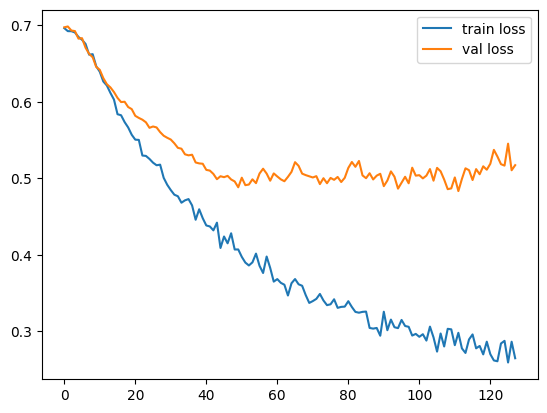

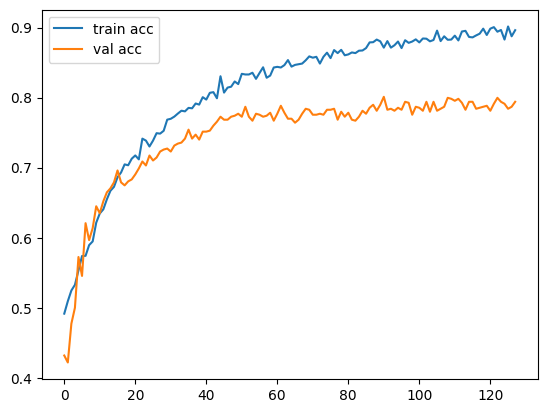

In [744]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend()
plt.show()

In [745]:
model.evaluate(valid_dataset)

22/22 [==============================] - 0s 762us/step - loss: 0.2153 - accuracy: 0.9190


[0.2152518779039383, 0.9190340638160706]

In [647]:
# TO IGNORE
import matplotlib.pyplot as plt

for data, labels in test_dataset.as_numpy_iterator():
    model_pred = model.predict(data);
    model_pred = [np.argmax(p) for p in model_pred]
    for i, d in enumerate(data):
        if int(labels[i]) != model_pred[i]:
            continue
            plt.plot(data[i])
            plt.show()    
            # print(list(map(float, data[i])), labels[i], model_pred[i])
            print(labels[i], model_pred[i])
        else:
            if labels[i] != 0:
                continue
            # print(labels[i], model_pred[i])
            # plt.plot(data[i])
            # plt.show() 
            # print(str(list(data[i])))
            # print(f"float s_signal[] = {' '.join(str(list(data[i])).split(' '))};")
            # for j in range(len(data[i])):
            #     print(f"input->data.f[{j}] = {float(data[i][j])};")
    break



2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 12ms/step
[342, 362]


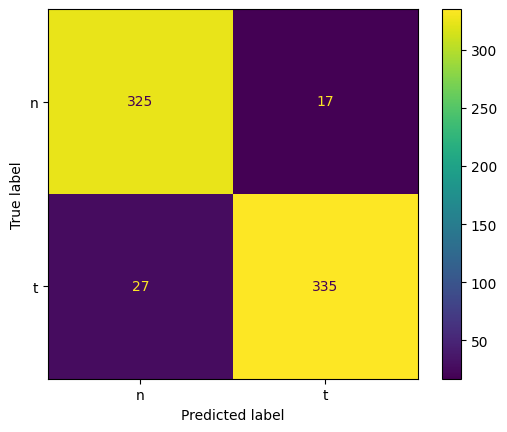

In [734]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

true = []
pred = []

label = [0, 0]

for data, labels in test_dataset.as_numpy_iterator():
    model_pred = model.predict(data);
    
    model_pred = [1 if pred[0] > 0.5 else 0 for pred in model_pred]

    # model_pred = [np.argmax(p) for p in model_pred]

    for x in labels:
        label[int(x)] += 1

    true += list(labels)
    pred += model_pred

print(label)

conf = confusion_matrix(true, pred)

disp = ConfusionMatrixDisplay(conf, display_labels=['n', 't'])

disp.plot()
plt.show()

In [739]:
model.summary()

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_636 (Dense)           (None, 64)                2112      
                                                                 
 dropout_95 (Dropout)        (None, 64)                0         
                                                                 
 dense_637 (Dense)           (None, 64)                4160      
                                                                 
 dropout_96 (Dropout)        (None, 64)                0         
                                                                 
 dense_638 (Dense)           (None, 32)                2080      
                                                                 
 dropout_97 (Dropout)        (None, 32)                0         
                                                                 
 dense_639 (Dense)           (None, 32)             

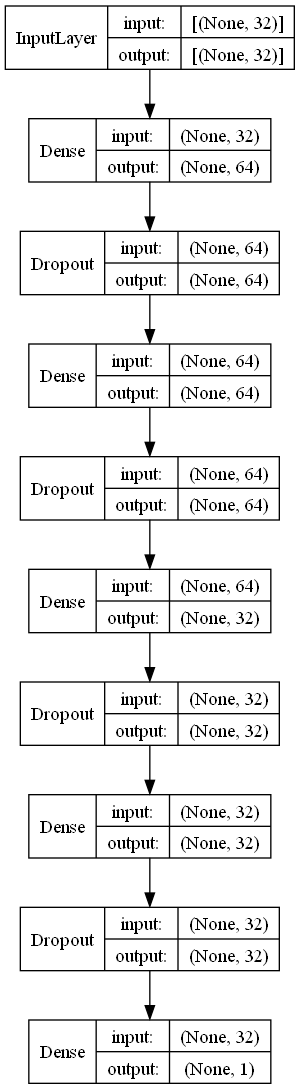

In [743]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [674]:
model.save('model_sf_32_80.h5')

In [733]:
model=tf.keras.models.load_model("./model_sf_32_80.h5")

In [676]:
import os

# def representative_dataset():
#   for data in test_dataset.take(100):
#     yield [d for d in data[0]]

def convert_tflite_model(model):
    """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format."""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # converter.representative_dataset = representative_dataset
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    # converter.inference_input_type = tf.int8  # or tf.uint8
    # converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_model = converter.convert()
    return tflite_model


def save_tflite_model(tflite_model, save_dir, model_name):
    """Save the converted tflite model."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, model_name)
    with open(save_path, "wb") as f:
        f.write(tflite_model)
    # logging.info("Tflite model saved to %s", save_dir)

In [677]:
tf_lite_model = convert_tflite_model(model)

save_tflite_model(tf_lite_model, '.', 'model_sf_32_80.tflite')

INFO:tensorflow:Assets written to: C:\Users\Amd\AppData\Local\Temp\tmp2r9yzer9\assets


INFO:tensorflow:Assets written to: C:\Users\Amd\AppData\Local\Temp\tmp2r9yzer9\assets


In [653]:
interpreter = tf.lite.Interpreter(model_content=tf_lite_model)
print(interpreter.get_signature_list())

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# interpreter.set_tensor(input_index, )
# interpreter.invoke()
interpreter.get_output_details()

{'serving_default': {'inputs': ['input_173'], 'outputs': ['dense_622']}}


[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]